# Integro Differential Equations
Looking at Schaum, Jerono (2019), we can use the provided PDE for modeling the growth population. This results in the following Equation: 
$$
\frac{\partial n(m,t)}{\partial t} = 
- \frac{\partial}{\partial m} \left[ r_g(m, S) \, n(m, t) \right] 
- \Gamma(m, S) \, n(m, t) 
+ 2 \int_m^{m_{\text{max}}} \Gamma(m', S) \, p(m' \to m) \, n(m', t) \, dm' 
- D \, n(m, t)
$$
$$
\dot{S}(t) = - \int_0^{m^+} r_{g}(m, S) \, n(m, t) \, dm
$$
Note that when solving numerically, i do not use the chain rule for the derivative with regards to $m$ (even though i probably should...). Simply because it is easier to implement numerically and i enforce the assumption that the growth rate is independent of the cell mass.The goal is simply to test a NN, so i am not really bothered with the details of the DGL This assumption might not be accurate, however it simplifies the equation.
Therefore we make the approximation : 
$$
\frac{\partial}{\partial m} \left[ r_g \, n \right] 
\approx \frac{(r_g \, n)_i - (r_g \, n)_{i-1}}{\Delta m}
$$ 

Since $n=f(m,t)$ we have to solve this numerically. Therefore we discretize the System over the mass-Domain with regards to $$\Delta m=m_{i}-m_{i-1}$$ and then solve it for small time increments $\Delta t$. Basically creating a System of ODEs for each incremental Distribution $n_{i}$

Now to make this look more "mathematical" i introduce :
$$
\begin{aligned}
& \Delta m = m_i - m_{i-1}  ,  i  \epsilon [1,M] \\
& n_i(t) \approx n(m_i, t) \\
& r_{g,i}(S) = r_g(m_i, S) \\
& \Gamma_i(S) = \Gamma(m_i, S) \\
& p_{k \to i} \approx p(m_k \to m_i)
\end{aligned}
$$
The integral term can be approximated by the sum over the increments,so that for each $n_{i}$ we can apply : 
$$
\frac{d n_i}{dt} = 
- \frac{(r_g \, n)_i - (r_g \, n)_{i-1}}{\Delta m}
- \Gamma_i(S) \, n_i
+ 2 \sum_{k=i}^{M} \Gamma_k(S) \, p_{k \to i} \, n_k \, \Delta m
- D \, n_i
$$
and also the additional condition for the Substrate :
$$
\frac{dS}{dt} = - \sum_{i=0}^{M} r_{g,i}(S) \, n_i \, \Delta m
$$

Now lets get to coding...



# Numeric Simulation

In [39]:
#imports
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random #for random starting values around a mean value 
import math
import torch
import torch.nn as nn
from functools import partial
import pickle
import Training_data_integro_diff_batch.All_Models as models
import Training_data_integro_diff_batch.Training_helper as helper
import gpytorch
import Observer_integro_diff as obs

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


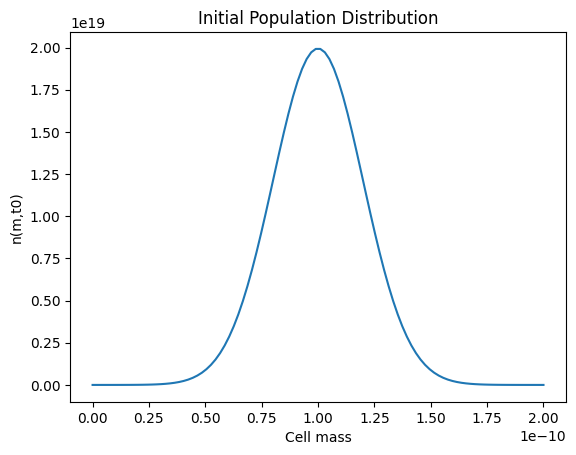

In [40]:
#domain and parameters
M  =  100
m_min,  m_max   =    0.0,    2e-10
minimal_division_mass=0
m = np.linspace(m_min, m_max, M)
delta_m = m[1] - m[0]

q=5         #for the probability distribution- important--> q>1. for q<1--> divergence, p=1--> P[k:, 0] is not 0 anymore (cells could falsly split into cells of size 0!)
Bqq = math.gamma(q) * math.gamma(q) / math.gamma(2*q)
se=5


#functions for growth rate/death rate...
def r_g (m_i, S):
    ks_max=0.8
    K_s=2
    rho = (ks_max * S)/ (K_s+S)             #Monod Kinetics for the growth rate 
    r_g=rho*m_i 
    return r_g

def Gamma(m_i,S,minimal_division_mass):
    # beta = 5
    eps=1e-12
    # gamma_m=np.where(m_i < minimal_division_mass, 0, beta *m_i)  # if m_i < minimal_division_mass, then gamma = 0
    gamma_m = 1 / (m_max-m_i+eps)  - 1/ (m_max-minimal_division_mass+eps)
    return gamma_m * r_g(m_i, S)


def build_P(m, q, Bqq,delta_m):
    M = len(m)
    P = np.zeros((M, M))
    for k in range(M):
        mk = m[k]
        if mk <= 0:
            continue
        # base beta density over daughters i < k
        x = m[:k] / mk
        nonzero_vals = (1.0 / Bqq) * (1.0 / mk) * (x ** (q - 1)) * ((1 - x) ** (q - 1))

        P[k, :k] = nonzero_vals
        # print(sum(nonzero_vals)*delta_m)
        #  (1) probability normalization: sum_i P[k,i] delta_m = 1
        Z = np.sum(P[k, :k]) * delta_m
        if Z > 0:
            P[k, :k] /= Z

        # (2) first moment: 2 * sum_i m_i P[k,i] Δm = m_k
        mom = np.sum(m[:k] * P[k, :k]) * delta_m
        if mom > 0:
            P[k, :k] *= (0.5 * mk / mom)
    return P
P=build_P(m,q,Bqq,delta_m)
#INPUTS
# Sinoid input
def D_func_1(t,i):
    return np.sin(t/i)/2.5 + 0.4
#step function
def D_func_2(t,i):
    return np.ones_like(t) * i
   
def population_system (t, y, m, P, delta_m, se, minimal_division_mass, i,D_func=None):
    n=y[:-1]
    S=y[-1] 
    dn_dt= np.zeros_like(n)


    r_g_values = r_g(m,S)
    Gamma_values=Gamma(m,S,minimal_division_mass)
    
    # Compute the finite difference approximation for ∂/∂m (r_g * n)
    rg_n = r_g_values * n
    rg_n[-1]=0                  #important! cells at maximum cell size cannot grow any further, thus do not take up any substrate!
    
    d_rg_n_dm = np.zeros_like(n)
    d_rg_n_dm[1:] = (rg_n[1:] - rg_n[:-1]) / (delta_m)

    # boundary treatment 
    d_rg_n_dm[0] = rg_n[0] /delta_m # is this correct?   
    
    
    #input
    if D_func is not None: 
        D_t = D_func(t, i)  # <-- get dilution rate at time t
    else : D_t=0
    #loss and gain terms 
    dilution_loss = D_t * n          
    division_loss = Gamma_values * n
    division_gain= 2.0 * delta_m * (Gamma_values * n) @ P
   
 
    flux_out = rg_n[-1]     #the theoretical flux that comes from the largest cells growing (BUT since they cant grow by construction, this term is incorporated to the dn_dt[-1])
    dn_dt = -d_rg_n_dm - division_loss + division_gain -dilution_loss
    dn_dt[-1] += flux_out / delta_m
   
    # Substrate equation
    dS_dt =  -np.sum(rg_n) *delta_m +D_t*(se-S)
    

    return np.concatenate([dn_dt, [dS_dt]])


# Initial population n_i



def shifted_gaussian(m, mu, sigma):
    """
    Gaussian-like curve on [0, m_max] with value 0 at m=0.
    
    Parameters:
        m      : scalar or array, domain values
        mu     : mean of the Gaussian
        sigma  : standard deviation of the Gaussian
    
    Returns:
        Gaussian-like values with f(0) = 0 AND a biomass of 1!
    """
    # Standard Gaussian
    g = np.exp(-0.5 * ((m - mu) / sigma) ** 2)
    
    # Subtract the value at m=0
    g0 = np.exp(-0.5 * ((0 - mu) / sigma) ** 2)
    g_shifted = g - g0
    
    # Clip to non-negative (avoid small numerical negatives)
    g_shifted = np.maximum(g_shifted, 0)
    
    # Normalize so the first momentum of the distribution with respect to the mass is 1 -->total biomass 
    
    total = np.sum(m * g_shifted)*delta_m
    g_shifted /= total
    
    return g_shifted
# Example usage


mu=0.5*m_max
sigma=0.1*m_max

n0 = shifted_gaussian(m,mu,sigma)   *  0.1            #-->biomass at start =0.1 gramm
plt.plot(m,n0)
plt.title('Initial Population Distribution')
plt.xlabel('Cell mass')
plt.ylabel('n(m,t0)')
plt.show()

                 # Normalize
      
# Initial substrate S
S0 = 5 #g/L

# Combine into single initial condition vector
y0 = np.concatenate([n0, [S0]])
t_span = (0.0, 30.0)
timesteps=300
t_eval = np.linspace(*t_span, timesteps)

# print(sum(n0*m*delta_m))
PDE= partial(
    population_system,
    m=m,
    P=P,
    delta_m=delta_m,
    se=se,
    minimal_division_mass=minimal_division_mass,
    D_func=D_func_1,
    i=1
)

sol = solve_ivp(PDE, t_span, y0, t_eval=t_eval, method='RK45')


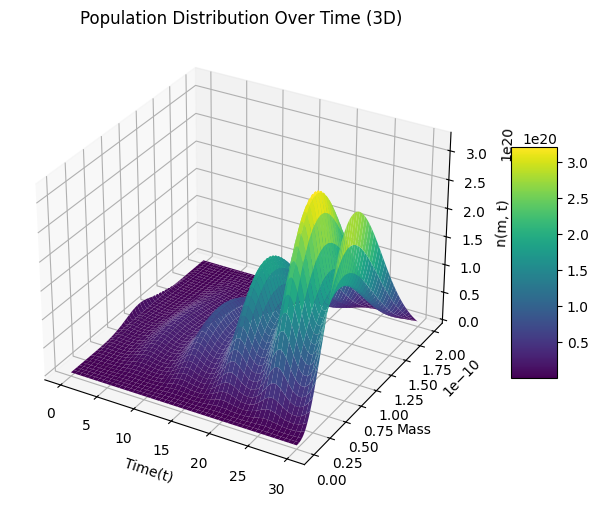

(100, 300)


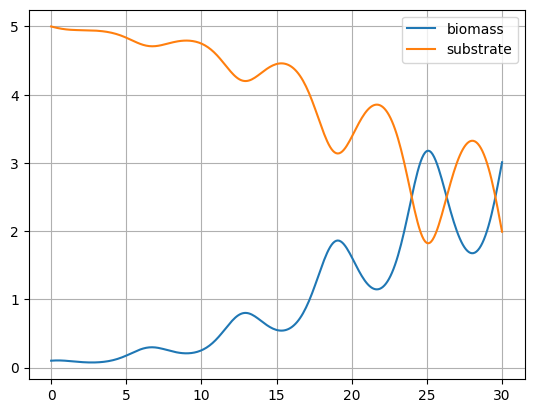

In [41]:
from mpl_toolkits.mplot3d import Axes3D

j=timesteps
# Create a meshgrid for mass (m) and time (t)
T, M_  = np.meshgrid(sol.t[:j], m)  #200x100

# Extract corresponding n(m, t) values for the first j time points
N = sol.y[:-1, :]  # m,t

# Create 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(T,M_ , N, cmap='viridis')

ax.set_xlabel('Time(t)')
ax.set_ylabel('Mass')
ax.set_zlabel('n(m, t)')
ax.set_title('Population Distribution Over Time (3D)')

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()

import plotly.graph_objects as go
import numpy as np


# pick a stride so you don’t draw too many lines
time_idxs = np.arange(0, N.shape[1], 2)

cmin, cmax = N.min(), N.max()
print(N.shape)
traces = []
for i, k in enumerate(time_idxs):
    traces.append(
        go.Scatter3d(
            x=M_[:, k],
            y=T[:, k],
            z=N[:, k],
            mode='lines',
            showlegend=False,           # still no legend for each line
            line=dict(
                color=N[:, k],          # color each point by its density
                colorscale='Viridis',
                cmin=cmin,
                cmax=cmax,
                width=4,
                showscale=(i == 0),       # only the first trace shows the colorbar, so i dont have 200 colorbars
                colorbar=dict(title='n(m, t)') if i == 0 else None
            )
        )
    )

fig = go.Figure(traces)
fig.update_layout(
    scene=dict(
        xaxis=dict(
            title='Mass (m)',
            autorange='reversed'    # flip so axis 0 and time axis 0 sort of fit better visually 
        ),
        yaxis=dict(title='Time (t)'),
        zaxis=dict(title='n(m, t)')
    ),
    width=700,
    height=700,
)
fig.show()

biomass=[]
for i in range(len(t_eval)):
    biomass.append(sum(N[:,i]*m*delta_m))

plt.figure()
plt.plot(t_eval,biomass,label='biomass')
plt.plot(t_eval,sol.y[-1, :],label='substrate')
plt.legend(loc='best')
plt.grid()
plt.show()



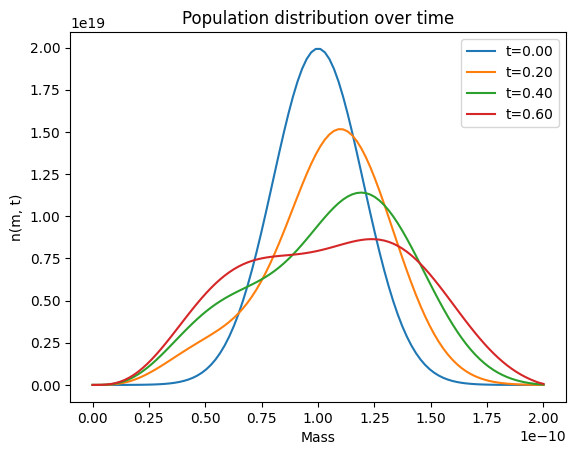

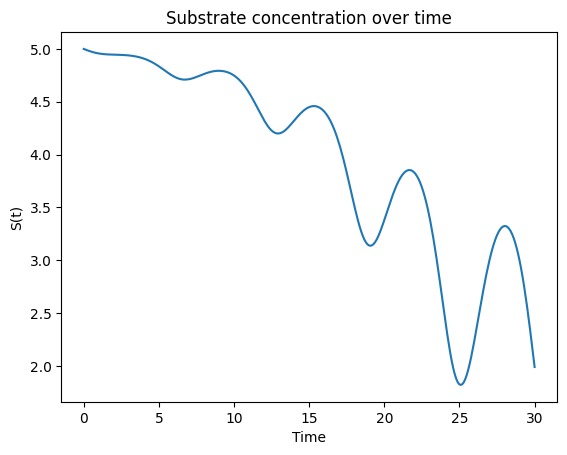

In [42]:


# Plot population distribution at different time steps
for idx in range(0,8,2):
    plt.plot(m, sol.y[:-1, idx], label=f't={sol.t[idx]:.2f}')
plt.xlabel('Mass')
plt.ylabel('n(m, t)')
plt.title('Population distribution over time')
plt.legend()
plt.show()

# Plot substrate over time
plt.plot(sol.t, sol.y[-1, :])
plt.xlabel('Time')
plt.ylabel('S(t)')
plt.title('Substrate concentration over time')
plt.show()



With the current (randomly chosen) rate $\Gamma$, larger cells/particles are affected a lot more, which is why the number of large cells decreases rapidly over time.


# Generating Training Data (batch first)
in easy [Cell_growth_easy_Model_with_input](https://github.com/therealtoby1/Master/blob/main/Cell_growth_easy_Model_with_input.ipynb), we trained a model with varying initial biomass and varying input functions. In this more elaborated model, we will also do this, but we will additionally incorporate different initial distributions (for the same biomass)
The way i will do this is i will take 3 distributions per initial condition ending up with :

  

In [43]:
# N_initial_conditions=10
# N_initial_distributions=3
# N_input_functions=2
# N_variations_per_function=5

# Dataset = {}
# B0_grid = np.linspace(0.1, 4.0, num=7)    # log spacing for biomass
# S0_grid = np.linspace(0, 4.0, num=7)      # linear for substrate
# print(B0_grid)
# #distributions
# mean = [0.25*m_max,
#         0.5*m_max,
#         0.75*m_max]

# sigma=0.1*m_max  

# # #input functions no input for now
# # Input_functions=[D_func_1,
# #                  D_func_2]
# # unique index for each dataset entry
# counter = 0  


            
# #TRAINING DATA FOR BATCH SYSTEM 
# for B0 in B0_grid:
#     initial_biomass=B0
#     for S0 in S0_grid:
#         for j in range (N_initial_distributions):
#                 n0 = shifted_gaussian(m,mean[j],sigma)   *  initial_biomass     
#                 y0 = np.concatenate([n0, [S0]])

#                 PDE= partial(
#                                 population_system,
#                                 m=m,
#                                 P=P,
#                                 delta_m=delta_m,
#                                 se=se,
#                                 minimal_division_mass=minimal_division_mass,
#                                 D_func=None,
#                                 i=None
#                 )
#                 t_span = (0.0, 10.0)
#                 timesteps=100
#                 t_eval= np.linspace(*t_span,timesteps)
#                 sol = solve_ivp(PDE, t_span, y0, t_eval=t_eval, method='RK45')
#                 entry = {
#                                 "n": sol.y[:-1, :],
#                                 "S": sol.y[-1, :],
#                                 "U": None,
#                                 "initial_substrate": S0,
#                                 "initial biomass": B0,
#                                 "mean": mean[j],
#                                 "sigma": sigma,
#                                 "D_func": None,
#                                 "tuning_param": None
#                         }
#                 Dataset[counter] = entry
#                 counter += 1
#                 # print(counter)
        
# # with open("Dataset_training_integro_diff_Batch.pkl", "wb") as f:
# #     pickle.dump(Dataset, f)




In [44]:
# #validation dataset for plotting: B0=3,S0=3
# Dataset_val = {}

# # Validation grids (midpoints example)
# B0_val = 0.5 * (B0_grid[:-1] + B0_grid[1:])
# S0_val = 0.5 * (S0_grid[:-1] + S0_grid[1:])

# # Slightly perturbed means for Gaussian distributions
# mean_val = [0.3*m_max, 0.6*m_max, 0.8*m_max]   # shifted vs training
# sigma_val = 0.1 * m_max

# counter = 0

# # BUILD VALIDATION DATA
# for B0 in B0_val:
#     initial_biomass = B0
#     for S0 in S0_val:
#         for j in range(len(mean_val)):
#             n0 = shifted_gaussian(m, mean_val[j], sigma_val) * initial_biomass
#             y0 = np.concatenate([n0, [S0]])

#             PDE = partial(
#                 population_system,
#                 m=m,
#                 P=P,
#                 delta_m=delta_m,
#                 se=se,
#                 minimal_division_mass=minimal_division_mass,
#                 D_func=None,
#                 i=None
#             )

#             t_span = (0.0, 10.0)
#             timesteps = 100
#             t_eval = np.linspace(*t_span, timesteps)

#             sol = solve_ivp(PDE, t_span, y0, t_eval=t_eval, method='RK45')

#             entry = {
#                 "n": sol.y[:-1, :],
#                 "S": sol.y[-1, :],
#                 "U": None,
#                 "initial_substrate": S0,
#                 "initial biomass": B0,
#                 "mean": mean_val[j],
#                 "sigma": sigma_val,
#                 "D_func": None,
#                 "tuning_param": None
#             }
#             Dataset_val[counter] = entry
#             counter += 1

# # with open("Dataset_validation_integro_diff_Batch.pkl", "wb") as f:
# #     pickle.dump(Dataset_val, f)




# Importing all models with trained parameters

In [287]:
#NN
M=100
classicNN=models.Neuralnetwork(dim=M+1)
model_feature_space=models.Neuralnetwork(dim=M+(2*(3*M+1))) #2 because training degree was 2
ResNet=models.ResNet(input_dim=M+1,hidden_dim=128,output_dim=M+1)

NN_state=torch.load("Training_data_integro_diff_batch/classic_NN_integro_diff_batch_2000_epoch_relu_5_layer_128.pth")
Resnet_state= torch.load("Training_data_integro_diff_batch/Resnet_integro_diff_batch_2000_epoch_relu_4blocks_128.pth")
feature_NN_state= torch.load("Training_data_integro_diff_batch/Feature_NN_integro_diff_batch_3000_epoch_relu_5_layer_128.pth")

classicNN.load_state_dict(NN_state)
ResNet.load_state_dict(Resnet_state)
model_feature_space.load_state_dict(feature_NN_state)

classicNN.eval()
ResNet.eval()
model_feature_space.eval()

#GP
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=M+1)
num_latents=12
inducing_shape= (12, 128, 101)                      #inducing shape used in the training
dummy_Z = torch.zeros(inducing_shape)

Sparse_LMC_GP = models.SparseLMCMultitaskGP(dummy_Z,num_tasks=M+1)
GP_state=torch.load("Training_data_integro_diff_batch/Sparse_Multitask_GP_12_latents.pth")

# Load trained weights
Sparse_LMC_GP.load_state_dict(GP_state['model_state_dict'])
likelihood.load_state_dict(GP_state['likelihood_state_dict'])

Sparse_LMC_GP.eval()


#EDMD:
edmd_mat=torch.load("Training_data_integro_diff_batch/EDMD_matrices.pth")
#normalization_scales:
norm_scales=torch.load("Training_data_integro_diff_batch/normalization_scales.pth")


# UKF
the way i set it up the UKF takes place in the normalized space (otherwise the numbers get too big--> Nan values), so the user passes n_max and s_max (that was used in the training and can be found in the normalization_scales.pkl) and can also assign the covariance matrices. in the end i plot the stuff


In [290]:
#load dataset for comparison
with open("Training_data_integro_diff_batch\Dataset_validation_integro_diff_Batch.pkl", "rb") as f:
    Dataset_validation = pickle.load(f)

N_pde= Dataset_validation[10]["n"]
S_pde=Dataset_validation[10]["S"]
biomass_measurement= (N_pde  * m[:,None]).sum(axis=0) * delta_m

noise_std = 0.05 * biomass_measurement.max()   # e.g. 5% of max biomass
biomass_noisy = biomass_measurement + np.random.normal(0, noise_std, size=biomass_measurement.shape)

m_torch=torch.linspace(0,2e-10,M)
delta_m_torch=(m_torch[1]-m_torch[0]).item()


n0 = torch.tensor(Dataset_validation[10]["n"][:, 0], dtype=torch.float32)/2
s0 = torch.tensor(Dataset_validation[10]["S"][0], dtype=torch.float32)/2
x0 = torch.cat([n0, s0.view(1)], 0)



def h_model(x, m_torch, delta_m_torch, n_max):
    n_norm = x[:-1]
    biomass = (n_norm * m_torch).sum() * delta_m_torch * n_max
    return biomass.view(1)   # (1,)


# wrap f_model and h_model

h = lambda x: h_model(x, m_torch, delta_m_torch, norm_scales["n_max"])



## Classic Neural Network 


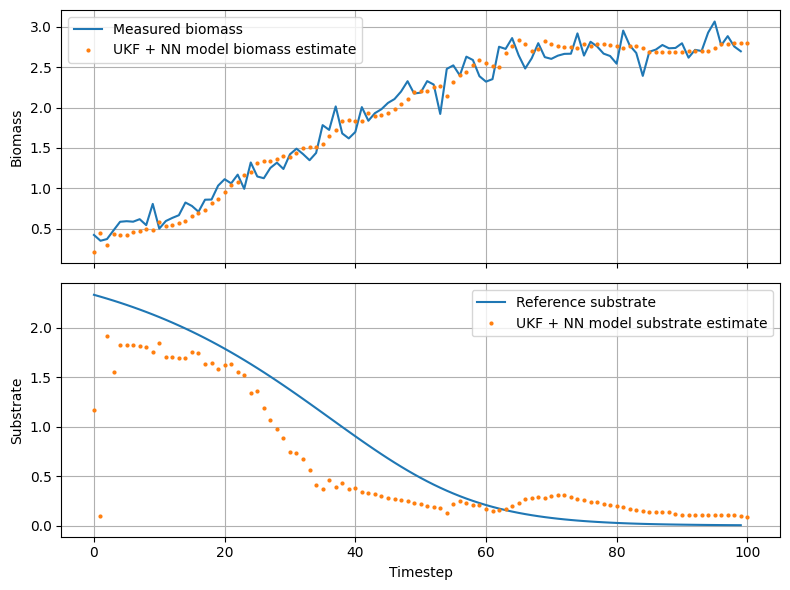

In [291]:
f = lambda x, u=None: obs.f_model_NN(x, classicNN)
ukf_classic_NN = obs.UKF(state_dim=M+1,
                        meas_dim=1, 
                        f_model=f, 
                        h_model=h,
                        n_max=norm_scales["n_max"],         #for normalization
                        s_max=norm_scales["S_max"])


ukf_classic_NN.set_initial_state(x0)            #applies normalization so the model doesnt result in Nans
ukf_classic_NN.P = torch.eye(ukf_classic_NN.n) * 1e-1                 # bigger initial uncertainty
ukf_classic_NN.Q = torch.eye(ukf_classic_NN.n) * 1e-5

ukf_classic_NN.R= 0.05*biomass_measurement.max()

X_estimates=ukf_classic_NN.run(U_seq=None,
                               Y_seq=torch.tensor(biomass_noisy,dtype=torch.float32)) 

# --------- PLOTS ---------
# 1) biomass: measured vs estimated
ukf_classic_NN.plot_results(
    X_estimates,
    biomass_noisy,
    S_reference=S_pde,
    m_torch=m_torch,
    delta_m_torch=delta_m_torch,
    title_prefix="UKF + NN model"
)


## Feature Space lifted NN


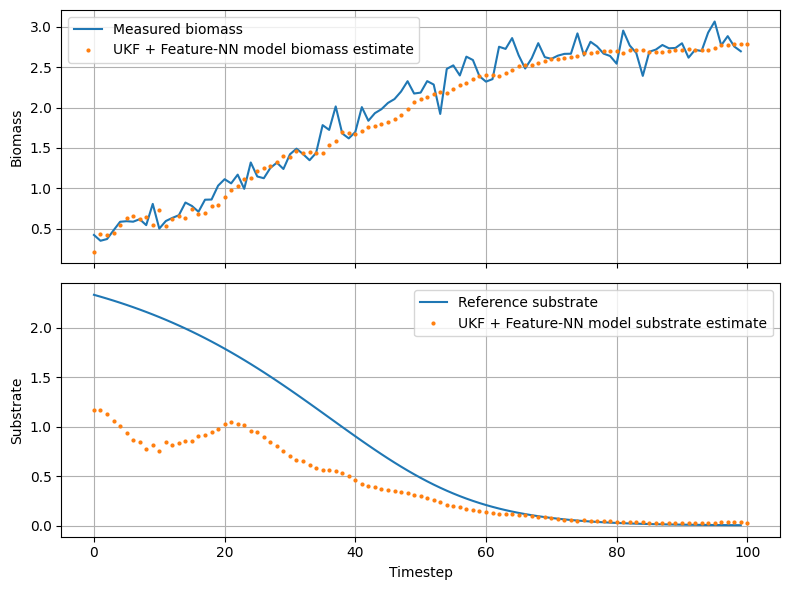

Biomass metrics: {'RMSE': 0.11819221079349518, 'MAE': 0.09614614397287369, 'MaxError': 0.26279783248901367, 'Rel_L2': 0.05597410082686078, 'time_in_tol': 0.5757575631141663, 'settling_time': 19, 'tolerance_used': 0.09746464490890504}
Substrate metrics: {'RMSE': 0.6056884527206421, 'MAE': 0.40764814615249634, 'MaxError': 1.3832348585128784, 'Rel_L2': 0.5284962250382678, 'time_in_tol': 0.3636363744735718, 'settling_time': 63, 'tolerance_used': 0.0404520183801651}


In [298]:
f = lambda x, u=None: obs.f_model_NN_feature_space(model_feature_space, x, degree=2, steps=1)
ukf_feature_NN = obs.UKF(state_dim=M+1,
                         meas_dim=1, 
                         f_model=f, 
                         h_model=h,
                         n_max=norm_scales["n_max"],         # for normalization
                         s_max=norm_scales["S_max"])

ukf_feature_NN.set_initial_state(x0)            # applies normalization so the model doesn’t result in NaNs
ukf_feature_NN.P = torch.eye(ukf_feature_NN.n) * 1e-1   # bigger initial uncertainty
ukf_feature_NN.Q = torch.eye(ukf_feature_NN.n) * 1e-4
ukf_feature_NN.R = 0.05 * biomass_measurement.max()

X_estimates = ukf_feature_NN.run(U_seq=None,
                                 Y_seq=torch.tensor(biomass_noisy, dtype=torch.float32)) 

# --------- PLOTS ---------
# 1) biomass: measured vs estimated
ukf_feature_NN.plot_results(
    X_estimates,
    biomass_noisy,
    S_reference=S_pde,
    m_torch=m_torch,
    delta_m_torch=delta_m_torch,
    title_prefix="UKF + Feature-NN model"
)
metrics = ukf_feature_NN.evaluate_errors(
    X_estimates,
    biomass_true=biomass_measurement,
    S_true=S_pde,
    m_torch=m_torch,
    delta_m_torch=delta_m_torch,
    rel_tol=0.05,   # 5% tolerance
    abs_tol=1e-3,   # absolute floor
    window=10       # must stay within tol for 10 steps
)

print("Biomass metrics:", metrics["biomass"])
print("Substrate metrics:", metrics["substrate"])


## ResNet

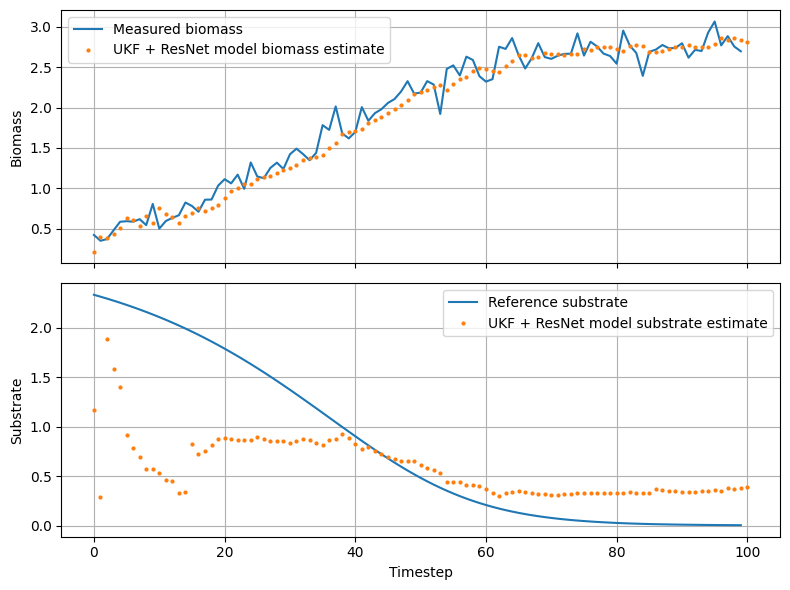

In [294]:
f = lambda x, u=None: obs.f_model_NN(x, ResNet)
ukf_ResNet = obs.UKF(state_dim=M+1,
                     meas_dim=1, 
                     f_model=f, 
                     h_model=h,
                     n_max=norm_scales["n_max"],         # for normalization
                     s_max=norm_scales["S_max"])

ukf_ResNet.set_initial_state(x0)            # applies normalization so the model doesn’t result in NaNs
ukf_ResNet.P = torch.eye(ukf_ResNet.n) * 1e-1                  # bigger initial uncertainty
ukf_ResNet.Q = torch.eye(ukf_ResNet.n) * 1e-4
ukf_ResNet.R = 0.05 * biomass_measurement.max()

X_estimates = ukf_ResNet.run(U_seq=None,
                             Y_seq=torch.tensor(biomass_noisy, dtype=torch.float32)) 

# --------- PLOTS ---------
# 1) biomass: measured vs estimated
ukf_ResNet.plot_results(
    X_estimates,
    biomass_noisy,
    S_reference=S_pde,
    m_torch=m_torch,
    delta_m_torch=delta_m_torch,
    title_prefix="UKF + ResNet model"
)

## Multivariate Gaussian Process


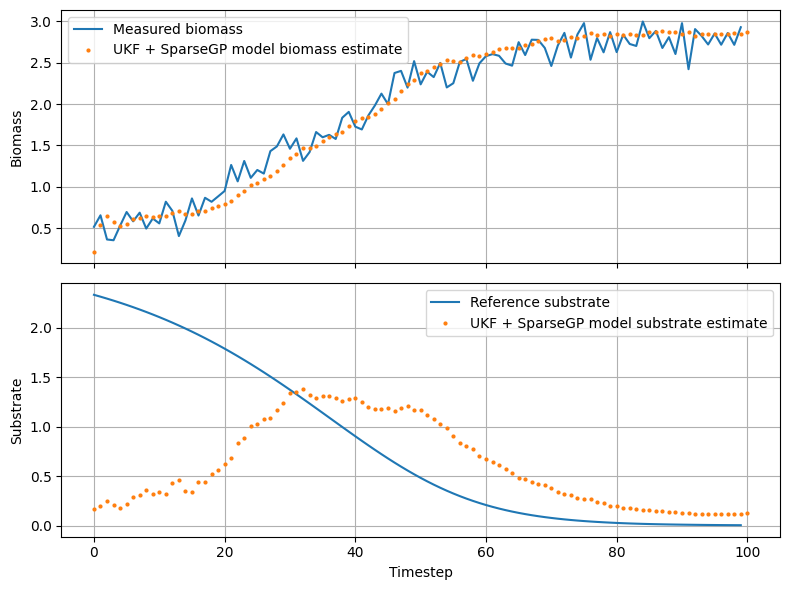

In [268]:
f = lambda x, u=None: obs.f_model_GP(x, likelihood=likelihood,model=Sparse_LMC_GP)
ukf_SparseGP = obs.UKF(state_dim=M+1,
                       meas_dim=1, 
                       f_model=f, 
                       h_model=h,
                       n_max=norm_scales["n_max"],         # for normalization
                       s_max=norm_scales["S_max"])

ukf_SparseGP.set_initial_state(x0)            # applies normalization so the model doesn’t result in NaNs
ukf_SparseGP.P = torch.eye(ukf_SparseGP.n) * 1e-1                  # bigger initial uncertainty
ukf_SparseGP.Q = torch.eye(ukf_SparseGP.n) * 1e-4
ukf_SparseGP.R = 0.05 * biomass_measurement.max()

X_estimates = ukf_SparseGP.run(U_seq=None,
                               Y_seq=torch.tensor(biomass_noisy, dtype=torch.float32)) 

# --------- PLOTS ---------
# 1) biomass: measured vs estimated
ukf_SparseGP.plot_results(
    X_estimates,
    biomass_noisy,
    S_reference=S_pde,
    m_torch=m_torch,
    delta_m_torch=delta_m_torch,
    title_prefix="UKF + SparseGP model"
)


## DMD 
DMD will likely not look good so i jump straight to **EDMD**

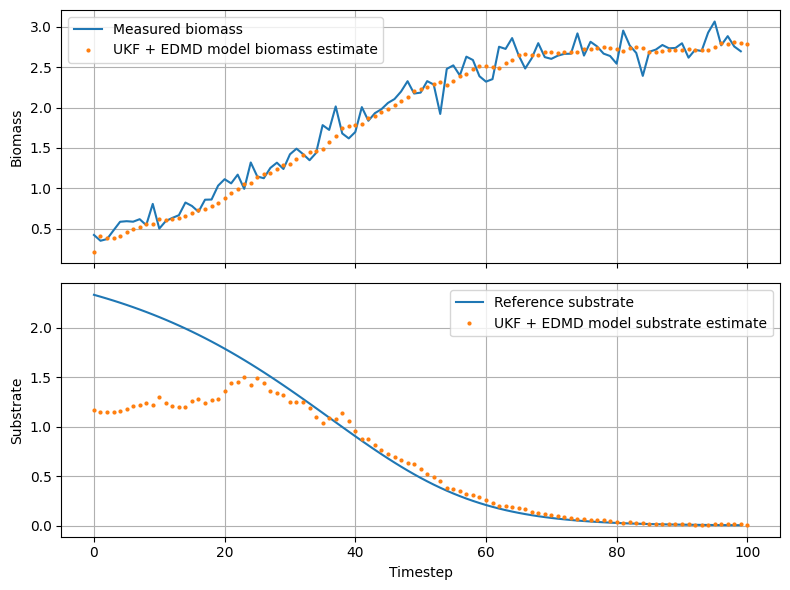

In [295]:
K_tilde = edmd_mat["K_tilde"]
U_r     = edmd_mat["U_r"]
degree  = edmd_mat["degree"]

f = lambda x, u=None: obs.f_model_EDMD(x,U_r=U_r,K_tilde=K_tilde,degree=degree)
ukf_edmd = obs.UKF(state_dim=M+1,
                   meas_dim=1, 
                   f_model=f, 
                   h_model=h,
                   n_max=norm_scales["n_max"],         # for normalization
                   s_max=norm_scales["S_max"])

ukf_edmd.set_initial_state(x0)            # applies normalization so the model doesn't result in NaNs
ukf_edmd.P = torch.eye(ukf_edmd.n) * 1e-1  # bigger initial uncertainty
ukf_edmd.Q = torch.eye(ukf_edmd.n) * 1e-4
ukf_edmd.R = 0.05 * biomass_measurement.max()

X_estimates = ukf_edmd.run(U_seq=None,
                           Y_seq=torch.tensor(biomass_noisy, dtype=torch.float32)) 

# --------- PLOTS ---------
# 1) biomass: measured vs estimated
ukf_edmd.plot_results(
    X_estimates,
    biomass_noisy,
    S_reference=S_pde,
    m_torch=m_torch,
    delta_m_torch=delta_m_torch,
    title_prefix="UKF + EDMD model"
)

## Summary
clear winner is EDMD... it captures the dynamics really well and works suprisingly good across a large range of validation datasets

# Error estimation
Note that we only used our Model for the first half of the dataset that we calculated using the PDE so i only care about the mistake in the "predicted" part of the Neural Network, not the part that i specifically used the training data on.

In [ ]:
error=[]
# Calculate the error between the neural network predictions and the original solution (only for the Mass distribution!! not the substrate)
print(N_nn.shape)
print(sol.y[:-1].shape)
print(M)
for i in range(len(t_eval)):
    er=0
    for j in range (M):
        er+= np.linalg.norm(N_nn[j, i] - N_pde[j,i])/(M)
    error.append(er)


# Plot error over time as a separate plot
plt.figure()
plt.plot(t_eval[:timesteps], error)
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Neural Network Prediction Error Over Time for n(m, t)')
plt.show()

#
plt.figure(figsize=(15, 4))

# t=0
plt.subplot(1, 3, 1)
plt.plot(N_nn.T[1], label="NN prediction (t=1)")
plt.plot(N_pde.T[1], label="PDE solution (t=1)")
plt.xlabel("mass (m)")
plt.ylabel("n(m, t)")
plt.title("t = 1")
plt.legend()

# t=50
plt.subplot(1, 3, 2)
plt.plot(m,N_nn.T[49], label="NN prediction (t=100)")
plt.plot(m,N_pde.T[49], label="PDE solution (t=100)")
plt.xlabel("mass (m)")
plt.title("t = 10")
plt.legend()

# t=199
plt.subplot(1, 3, 3)
plt.plot(N_nn.T[299], label="NN prediction (t=300)")
plt.plot(N_pde.T[299], label="PDE solution (t=300)")
plt.xlabel("mass (m)")
plt.title("t = 30")
plt.legend()


plt.suptitle("Comparison of NN and PDE at Different Timesteps")
plt.tight_layout()

plt.show()

plt.figure()
plt.title('comparison of substrate concentration ')
plt.plot(t_eval[:timesteps],S_pde)
plt.plot(t_eval[:timesteps],S_nn)
plt.legend(['Substrate concentration','NN Substrate prediction'])
plt.xlabel('Time')
plt.ylabel('Substrate concentration')
plt.show()

NameError: name 'N_nn' is not defined

# Conclusion
For this first attempt it appears that after we exceed the point of the training data, the model error grows rapidly. Obviously this is expected. However, it is noticable that after  the 50th timestep (approx at 2.5 seconds- the last timestep used for training), there is almost no change in the values estimated by the Neural Network. This can easily be observed in the Graph for the NN Substrate prediction

Why does this happen?

At first i was kind of expecting the NN to keep fitting the Data or at least fit the Data better, but since i only used 1 Dataset and only trained the model with  the first few seconds of that data, there was no training done using lower Substrate concentrations (as they would occur after timestep 50), so  the calculation of the DGL at lower Substrate concentrations simply would be outside the scope of the NN. To achieve better estimation i would need more training data that covers the entire range of possible substrate concentrations as well as a few more validation data sets.
The same obviously holds true for the $n(m,t)$ estimation.

Tldr:

- Not enough training Data
- Values are outside the scope of the NN




# Next step:

Increase the accuracy by using a ***Physics-informed Neural Network*** (PINN). In a PINN, the knowledge of physics of specific system behaviour is used to extend the Neural Network. For this, the loss function needs to be tailored to the differential equation one assumes could describe the system. I know it is not a "source", but Wikipedia also says that this type of NN is particularly helpful for partial differential equations. The PINN should then be better suited to describe the model, even slightly outside of the training interval. In general, the loss function for a PINN is constructed as follows:

Assume that the dataset originates from a system that can be described by a general PDE: 
$$
\frac{\partial n}{\partial t} = \frac{\partial n}{\partial m} + f(c)
$$
Solving for zero gives us:
$$
\frac{\partial n}{\partial t} - \frac{\partial n}{\partial m} - f(c) = 0
$$
and this is the part that will now be added to the loss function, so that
the loss function for the PINN becomes:
$$
\mathcal{L} = \mathcal{L}_{\text{data}} + \lambda \, \mathcal{L}_{\text{PDE}}
$$
where $\mathcal{L}_{\text{data}}$ is the standard data loss (e.g., MSE between predicted and true values), $\mathcal{L}_{\text{PDE}}$ is the mean squared residual of the PDE:
$$
\mathcal{L}_{\text{PDE}} = \frac{1}{N} \sum_{i=1}^N \left| \left(\frac{\partial n}{\partial t}\right)_{\text{NN}} - \left(\frac{\partial n}{\partial m}\right)_{\text{NN}} - f(c) \right|^2
$$
and $\lambda$ is a weighting parameter that balances the two terms. This encourages the neural network to fit the data while also satisfying the underlying physics described by the PDE.


Here, $N$ represents the number of *collocation points*, i.e., the discrete points in the $(m, t)$ domain where the PDE residual is evaluated. 
Importantly, these collocation points do **not** have to coincide with the training data points; they can be chosen independently and even be sampled more densely or sparsely within the domain to enforce the physical constraints throughout the solution space. This flexibility allows the PINN to generalize the physical laws beyond just the observed data. Basically ensuring that the NN obeys the PDE across the whole domain